In [0]:
import torch
import torch.nn as nn
import PIL.Image as Image
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from glob import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary

In [0]:
images_path = './data/'
masks_path = './masks/'

In [0]:
data_files = glob(os.path.join(images_path+'/*tif'))
mask_files = glob(os.path.join(masks_path+'/*tif'))
len(data_files)

43

In [0]:
class BMMCdataset(Dataset):
    def __init__(self, image_path, target_path):   
        self.image_path = image_path
        self.target_path = target_path
        self.image_files = glob(os.path.join(image_path+'/*.tif'))
        self.mask_files = glob(os.path.join(target_path+'/*.tif'))
        self.transforms = transforms.ToTensor()
        self.mapping = {
            85: 0,
            170: 1,
            255: 2
        }
    
    def mask_to_class(self, mask):
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
        return mask

    def __getitem__(self, index):
        image = Image.open(self.image_files[index])
        mask = Image.open(self.mask_files[index])
        t_image = self.transforms(image)
        mask = torch.from_numpy(np.array(mask))
        mask = self.mask_to_class(mask)
        mask = mask.long()
        return t_image, mask

    def __len__(self): 
        return len(os.listdir(self.image_path))

In [0]:
dataset = BMMCdataset(images_path, masks_path)
train_data, val_data = train_test_split(dataset, test_size=0.2, shuffle=True)

print('Entire data:', len(dataset))
print('Train data:', len(train_data))
print('Val data:', len(val_data))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2) 
test_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=2)

for data, target in test_loader:
    print(torch.unique(target))

Entire data: 43
Train data: 34
Val data: 9
tensor([0, 1, 2])
tensor([0, 1])
tensor([0, 1, 2])
tensor([0, 1, 2])
tensor([0, 1, 2])
tensor([0, 1])
tensor([0, 1])
tensor([0, 1, 2])
tensor([0, 1])


In [0]:
# Unet model

class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, droup_rate = False):
        super(BaseConv, self).__init__()
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
        self.b1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.2, affine=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)
        self.b2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.2, affine=True)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.act(self.b1(x))
        x = self.conv2(x)
        x = self.act(self.b2(x))
        return x
    
    
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(DownConv, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, padding, stride)
    
    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x


class UpConv(nn.Module):
    def __init__ (self, in_channels, in_channels_skip, out_channels, kernel_size, padding, stride):
        super(UpConv, self).__init__()
        self.act = nn.ReLU()
        self.conv_trans1 = nn.ConvTranspose2d(in_channels + in_channels_skip, out_channels, kernel_size=2, padding=0, stride=2)
        self.b3 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.2, affine=True)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels= out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.b4 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.2, affine=True)
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.b5 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.2, affine=True)


    def forward(self, x, x_skip):
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_trans1(x)
        x = self.act(self.b3(x))
        x = self.conv3(x)
        x = self.act(self.b4(x))
        x = self.conv4(x)
        x = self.act(self.b5(x))
        return x
    
     
        
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, padding, stride, droup_rate = False):
        super(UNet, self).__init__()
        self.down1 = DownConv(in_channels, out_channels, kernel_size, padding, stride)#48     
        self.down2 = DownConv(out_channels, 2 * out_channels, kernel_size, padding, stride)#96
        self.down3 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, padding, stride)#192
        self.down4 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, padding, stride)#384        
        self.down5 = BaseConv(8 * out_channels, 16 * out_channels, kernel_size, padding, stride)#768
      
        self.up4 = UpConv(16 * out_channels, 8 * out_channels, 8 * out_channels, kernel_size, padding, stride)        
        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,  kernel_size, padding, stride)
        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, padding, stride)
        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, padding, stride)        
        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

        
    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        # Decoder
        x_up1 = self.up4(x5, x4)
        x_up2 = self.up3(x_up1, x3)
        x_up3 = self.up2(x_up2, x2)
        x_up4 = self.up1(x_up3, x1)

        x_out = F.log_softmax(self.out(x_up4), 1)
        return x_out

In [0]:
def train_model(model, train_data, loss, optimizer, scheduler, n_epochs):
  loss_history = []
  for epoch in range(n_epochs):
    model.train()
    loss_accum = 0   
    for i_step, (img, mask) in enumerate(train_data):
      # Get the inputs
      img, mask = img.to(device), mask.to(device)

      optimizer.zero_grad()

      outputs = model(img)
      loss_value = loss(outputs, mask)
      loss_value.backward()
      optimizer.step()
      scheduler.step()

      loss_accum += loss_value
    avg_loss = loss_accum / i_step
    print('Epoch {}, Loss: {}'.format(epoch+1, avg_loss))
  return loss_history  

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=1,
             out_channels=8,
             n_class=3,
             kernel_size=3,
             padding=1,
             stride=1)

model = model.to(device)
loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [0]:
loss_history = train_model(model, train_loader, loss, optimizer, scheduler, 20)

Epoch 1, Loss: 0.8053284883499146
Epoch 2, Loss: 0.5864547491073608
Epoch 3, Loss: 0.5587090253829956
Epoch 4, Loss: 0.535414457321167
Epoch 5, Loss: 0.5115352869033813
Epoch 6, Loss: 0.5034447908401489
Epoch 7, Loss: 0.4630124270915985
Epoch 8, Loss: 0.458542138338089
Epoch 9, Loss: 0.4482940137386322
Epoch 10, Loss: 0.433280348777771
Epoch 11, Loss: 0.4326827824115753
Epoch 12, Loss: 0.41653960943222046
Epoch 13, Loss: 0.42706039547920227
Epoch 14, Loss: 0.4152534604072571
Epoch 15, Loss: 0.4107142388820648
Epoch 16, Loss: 0.41281360387802124
Epoch 17, Loss: 0.40505364537239075
Epoch 18, Loss: 0.41374289989471436
Epoch 19, Loss: 0.41326382756233215
Epoch 20, Loss: 0.4126422703266144


In [0]:
outputs = []
for i, (x, y) in enumerate(test_loader):
  x = x.to(device)
  output = model(x)
  outputs.append(output)

In [0]:
prob = torch.exp(outputs[5])
prob.shape

torch.Size([1, 3, 1024, 1024])

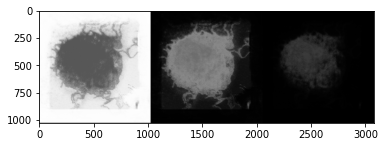

In [0]:
# predictions for every class
from torchvision.utils import make_grid

pred_grid = make_grid(prob.permute(1, 0, 2, 3), nrow=4)
pred_grid = pred_grid.detach()
pred_grid = pred_grid.to('cpu').permute(1, 2, 0).numpy()
plt.imshow(pred_grid)